<a href="https://colab.research.google.com/github/A-H-Sumon/FusionNet/blob/main/EfficientNet_B0NumtaDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d BengaliAI/numta --unzip

Dataset URL: https://www.kaggle.com/datasets/BengaliAI/numta
License(s): CC-BY-SA-4.0
 99% 1.89G/1.91G [00:09<00:00, 258MB/s]
100% 1.91G/1.91G [00:09<00:00, 208MB/s]


In [ ]:
!pip install opencv-python

In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split
# ======================== Directories and DataFrames ========================
base_path = "/content"
# Load and combine all labeled training data
all_image_paths = []
all_labels = []

for file_name in os.listdir(base_path):
    if file_name.startswith("training-") and file_name.endswith(".csv"):
        train_file_path = os.path.join(base_path, file_name)
        labels_df = pd.read_csv(train_file_path)
        folder_name = file_name.replace(".csv", "")
        folder_path = os.path.join(base_path, folder_name)

        if os.path.exists(folder_path):
            for _, row in labels_df.iterrows():
                image_file = row['filename']
                label = row['digit']
                image_path = os.path.join(folder_path, image_file)
                all_image_paths.append(image_path)
                all_labels.append(label)







X_train, X_test, y_train, y_test = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

# ===================== Create DataFrames =====================
train_df = pd.DataFrame({"image_path": X_train, "label": y_train})
test_df = pd.DataFrame({"image_path": X_test, "label": y_test})


print(f"Total training images: {len(train_df)}")
print(f"Total testing images: {len(test_df)}")

Total training images: 57636
Total testing images: 14409


In [ ]:
print(train_df['label'].unique())  # Check unique labels in the dataset
print(train_df['label'].nunique())

[8 9 5 7 6 0 3 1 2 4]
10


In [ ]:
test_df.to_csv('/content/drive/My Drive/test_df_numtadb.csv', index=False)

In [ ]:
# ======================== Data Preprocessing Function ========================
def preprocess_image(file_path):
    try:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Image not found or unreadable: {file_path}")
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        return img
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")
        return np.zeros((224, 224, 3), dtype=np.uint8)  # Placeholder for missing/invalid images


In [ ]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)  # Or use a dummy class


# ======================== Data Generators ========================
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',  # Include labels here
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',  # Ensure class mode is categorical
    shuffle=False
)


In [ ]:
import numpy as np
unique_labels, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(unique_labels, counts)))




{np.int64(0): np.int64(1448), np.int64(1): np.int64(1439), np.int64(2): np.int64(1445), np.int64(3): np.int64(1447), np.int64(4): np.int64(1450), np.int64(5): np.int64(1448), np.int64(6): np.int64(1442), np.int64(7): np.int64(1436), np.int64(8): np.int64(1431), np.int64(9): np.int64(1423)}


In [ ]:
print(test_df.head())  # Ensure 'label' column contains correct values


                       image_path label
0  /content/training-e/e03440.png     6
1  /content/training-a/a03102.png     2
2  /content/training-e/e11936.png     4
3  /content/training-e/e11757.png     3
4  /content/training-a/a08913.png     6


In [ ]:
# ======================== EfficientNet-B0 Model ========================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)#####ekhane edit
x = Dropout(0.3)(x)
output = Dense(len(train_df['label'].unique()), activation='softmax', dtype='float32')(x)


model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ======================== Callbacks ========================
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ======================== Model Training ========================
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ━━━━━━━━━━━━━━━━━━━━ 181s 53ms/step - accuracy: 0.7258 - loss: 0.8722 - val_accuracy: 0.9540 - val_loss: 0.2011
Epoch 2/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 120s 42ms/step - accuracy: 0.9192 - loss: 0.3127 - val_accuracy: 0.9596 - val_loss: 0.1616
Epoch 3/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 139s 48ms/step - accuracy: 0.9309 - loss: 0.2627 - val_accuracy: 0.9603 - val_loss: 0.1574
Epoch 4/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 140s 48ms/step - accuracy: 0.9396 - loss: 0.2299 - val_accuracy: 0.9649 - val_loss: 0.1404
Epoch 5/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 137s 48ms/step - accuracy: 0.9452 - loss: 0.2044 - val_accuracy: 0.9690 - val_loss: 0.1226
Epoch 6/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 120s 42ms/step - accuracy: 0.9500 - loss: 0.1912 - val_accuracy: 0.9662 - val_loss: 0.1341
Epoch 7/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 161s 48ms/step - accuracy: 0.9511 - loss: 0.1829 - val_accuracy: 0.9704 - val_loss: 0.1164
Epoch 8/20
2882/2882 ━━━━━━━━━━━━━━━━━━━━ 119s 41ms/step - accuracy: 0.9520 - lo

In [ ]:
# ======================== Model Evaluation ========================
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

print("Test predictions completed.")

# Save the predictions
np.save("/content/drive/My Drive/test_predictions_numtadb.npy", predicted_labels)


901/901 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step
Test predictions completed.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.utils import to_categorical

# Get ground truth labels from generator
y_true = test_generator.labels  # integer encoded
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Accuracy & classification report
acc = accuracy_score(y_true, predicted_labels)
print(f"Test Accuracy: {acc:.2f}\n")

print(" Classification Report:")
print(classification_report(y_true, predicted_labels, target_names=class_names))


Test Accuracy: 0.97

 Classification Report:

              precision    recall  f1-score   support

           0       0.9901    0.9903    0.9902    1448
           1       0.9382    0.9104    0.9241    1439
           2       0.9619    0.9519    0.9569    1445
           3       0.9403    0.9216    0.9309    1447
           4       0.9911    0.9910    0.9910    1450
           5       0.9548    0.9538    0.9543    1448
           6       0.9284    0.9126    0.9204    1442
           7       0.9896    0.9896    0.9896    1436
           8       0.9790    0.9787    0.9788    1431
           9       0.9312    0.9113    0.9211    1423

    accuracy                           0.9660   14409
   macro avg       0.9605    0.9511    0.9557   14409
weighted avg       0.9659    0.9660    0.9659   14409
    


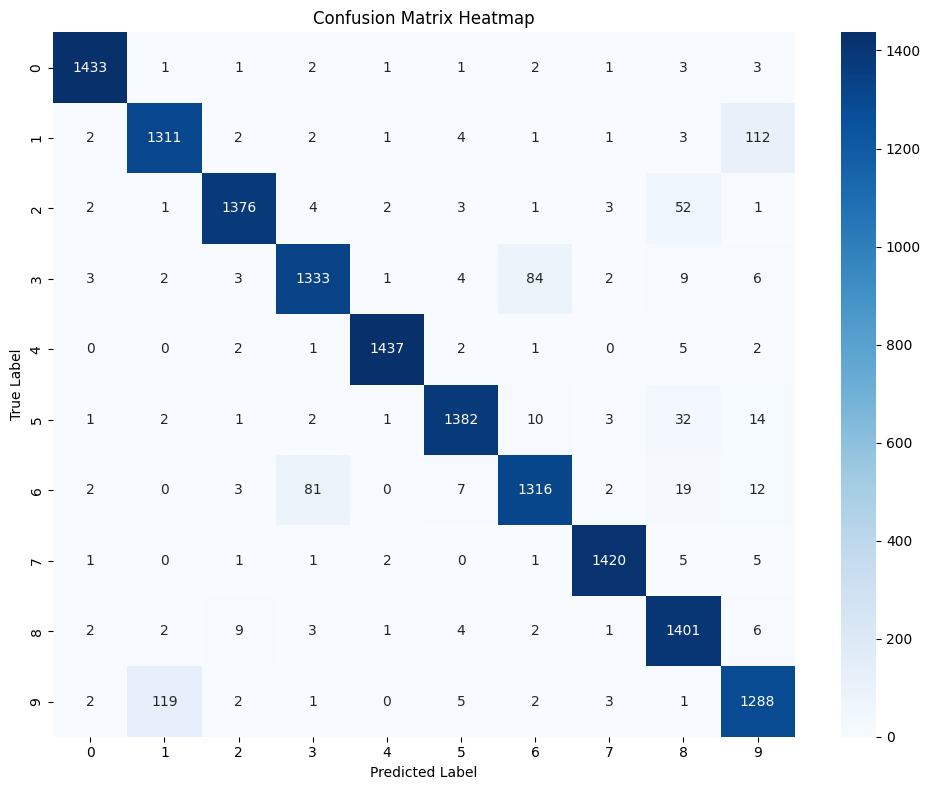

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

